# Fitting a Model with InSession

In [57]:
# ! git clone https://github.com/kelseymatsik/ds4002_project2.git

fatal: destination path 'ds4002_project2' already exists and is not an empty directory.


In [58]:
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"

x ='/content/ds4002_project2/data/cleaned_data2.csv'

# df = pd.read_csv(x)


df = pd.read_csv(file_path)

df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)

# Aggregate data
df_weekly = df.set_index("DateReported").resample("W").agg({
    "InSession": "max"  # 1 if UVA was in session at least once that week, else 0
}).reset_index()

# Add the CrimeCount column by counting rows per week
df_weekly["CrimeCount"] = df.resample("W", on="DateReported").size().values


# Rename columns for Prophet
df_weekly = df_weekly.rename(columns={"DateReported": "ds", "CrimeCount": "y"})

# Sort by date
df_weekly = df_weekly.sort_values("ds")

# Ensure 'ds' is in datetime format and remove timezone
df_weekly["ds"] = pd.to_datetime(df_weekly["ds"]).dt.tz_localize(None)

# Initialize model
model1 = Prophet(
    yearly_seasonality=True,  # Enable annual seasonality
    weekly_seasonality=True,  # Enable weekly seasonality
    daily_seasonality=False,  # Disable daily since it's too granular
)

# Add UVA regressor
model1.add_regressor("InSession")

# Fit model
model1.fit(df_weekly)

future1 = model1.make_future_dataframe(periods=52, freq="W")  # Predict 1 year ahead

# Add UVA session indicator to future data
future1["InSession"] = future1["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Predict
forecast1 = model1.predict(future1)

# Display forecast
forecast1[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()


<ipython-input-58-ccd3c4730d7d>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/226rpuie.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/kzmh_92v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84482', 'data', 'file=/tmp/tmpj6mptyxa/226rpuie.json', 'init=/tmp/tmpj6mptyxa/kzmh_92v.json', 'output', 'file=/tmp/tmpj6mptyxa/prophet_modelskhfm2zr/prophet_model-20250320190826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:26 - cmdstanpy - INFO - Chai

,ds,yhat,yhat_lower,yhat_upper
0,2019-10-06,78.329902,58.886955,97.420884
1,2019-10-13,81.595389,62.335550,102.324307
2,2019-10-20,89.974758,70.541920,109.994461
3,2019-10-27,95.464025,74.973040,115.606696
4,2019-11-03,92.114932,73.815352,112.605142


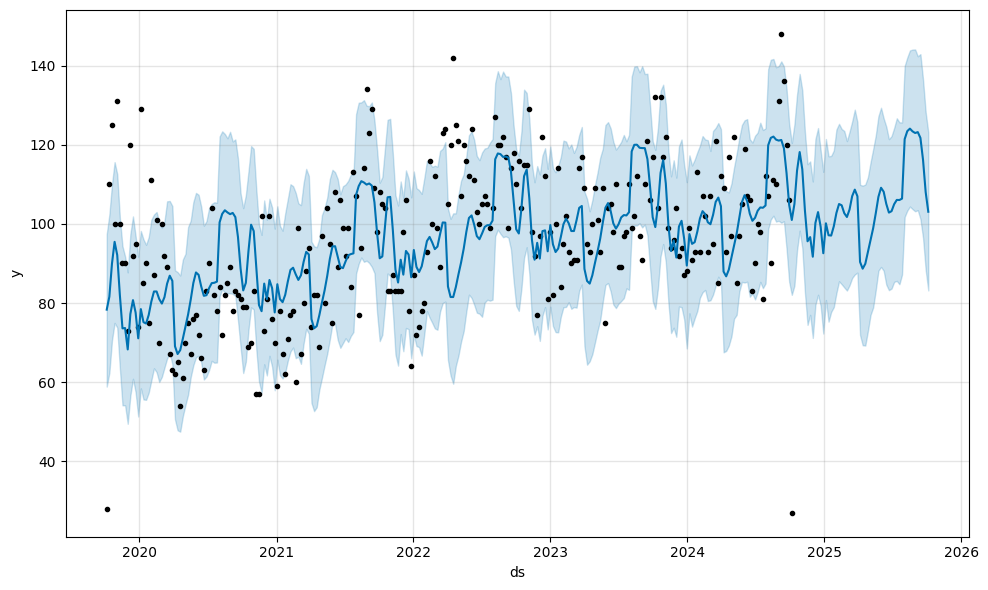

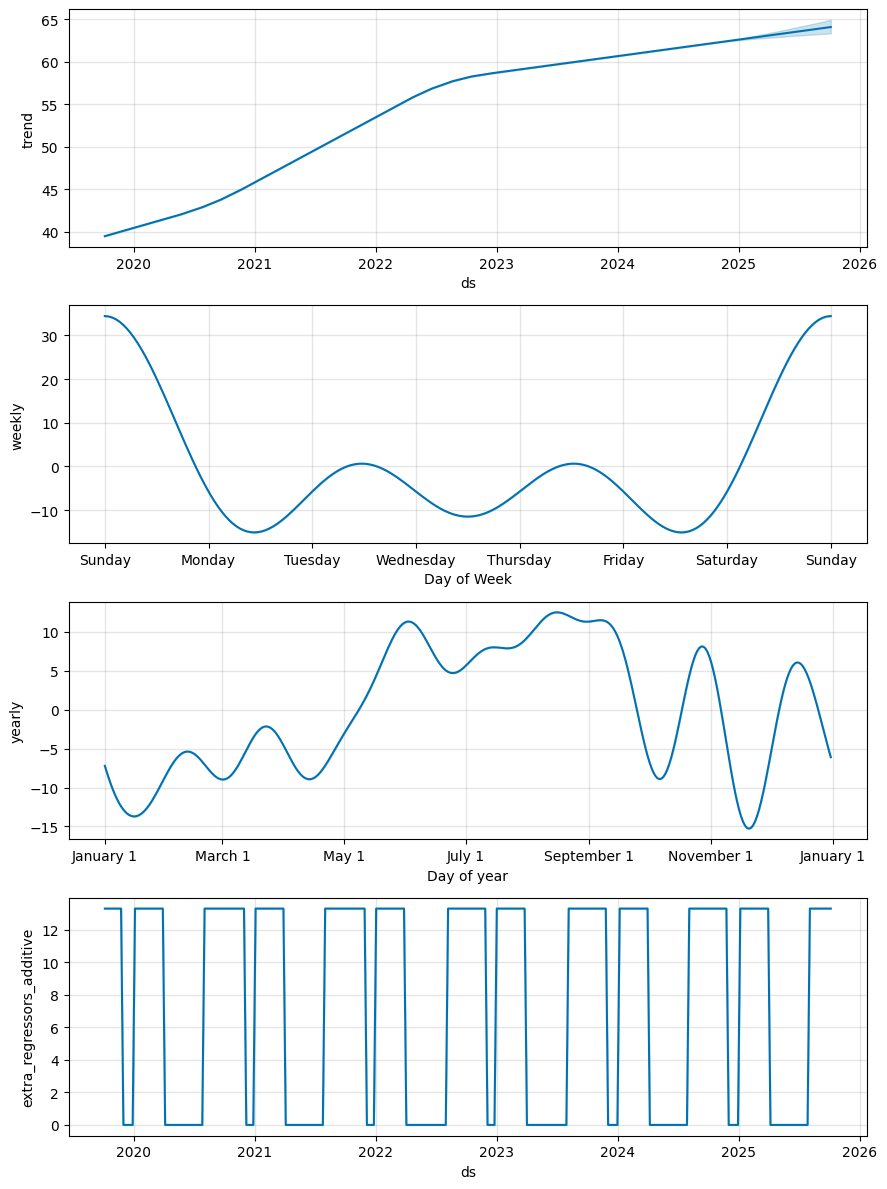

In [59]:
import matplotlib.pyplot as plt

# Plot forecast
fig = model1.plot(forecast1)
plt.show()

# Plot seasonality components
fig2 = model1.plot_components(forecast1)
plt.show()


In [60]:
# Evaluate model

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Use past data for testing
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

model_val1 = Prophet(
    yearly_seasonality=True,  # Enable annual seasonality
    weekly_seasonality=True,  # Enable weekly seasonality
    daily_seasonality=False,  # Disable daily since it's too granular
)

# Fit on training set
model_val1.fit(train)

# Predict on test set
test_forecast1 = model_val1.predict(test)

# Evaluate
mae1 = mean_absolute_error(test["y"], test_forecast1["yhat"])
rmse1 = root_mean_squared_error(test["y"], test_forecast1["yhat"])
r2_1 = r2_score(test["y"], test_forecast1["yhat"])

print(f"MAE: {mae1}")
print(f"RMSE: {rmse1}")
print(f"R²: {r2_1}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/1vv1bds6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/lpu2kavq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22338', 'data', 'file=/tmp/tmpj6mptyxa/1vv1bds6.json', 'init=/tmp/tmpj6mptyxa/lpu2kavq.json', 'output', 'file=/tmp/tmpj6mptyxa/prophet_modelrm4sdjv9/prophet_model-20250320190827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 12.134058085173404
RMSE: 17.47029119883316
R²: 0.06281792769508554


# Fitting a Model with Holidays (no InSession)

In [61]:
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"
#df = pd.read_csv(x)
df = pd.read_csv(file_path)



In [62]:
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"

#df = pd.read_csv(x)
df = pd.read_csv(file_path)

df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
df_weekly = df.resample("W", on="DateReported").size().reset_index()
df_weekly = df_weekly.rename(columns={"DateReported": "ds", 0: "y"})
df_weekly["ds"] = df_weekly["ds"].dt.tz_localize(None)
df_weekly = df_weekly.sort_values("ds")

# Define UVA holidays
uva_holidays = []
start_year, end_year = 2019, 2023

for year in range(start_year, end_year + 1):
    uva_holidays.extend([
        {"holiday": "Fall semester start", "ds": f"{year}-08-24"},
        {"holiday": "Fall semester end", "ds": f"{year}-12-06"},
        {"holiday": "Winter break start", "ds": f"{year}-12-07"},
        {"holiday": "Winter break end", "ds": f"{year}-01-17"},
        {"holiday": "Spring semester start", "ds": f"{year}-01-18"},
        {"holiday": "Spring semester end", "ds": f"{year}-05-02"},
        {"holiday": "Summer break start", "ds": f"{year}-05-03"},
        {"holiday": "Summer break end", "ds": f"{year}-08-23"},
    ])

# Convert holidays to DataFrame with window effects
uva_holidays = pd.DataFrame(uva_holidays)
uva_holidays["ds"] = pd.to_datetime(uva_holidays["ds"])
uva_holidays["lower_window"] = uva_holidays["holiday"].apply(lambda x: -5 if "break" in x else -2)
uva_holidays["upper_window"] = uva_holidays["holiday"].apply(lambda x: 5 if "break" in x else 2)

# Initialize Prophet model with holidays
model2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays  # Incorporate UVA holidays
)

# Fit model
df_weekly["ds"] = pd.to_datetime(df_weekly["ds"]).dt.tz_localize(None)
model2.fit(df_weekly)

# Make future predictions
future2 = model2.make_future_dataframe(periods=52, freq="W")
forecast2 = model2.predict(future2)

# Display forecast
forecast2[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()


<ipython-input-62-8876cb82a37b>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/mbtm5a4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/kyt1dvuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4804', 'data', 'file=/tmp/tmpj6mptyxa/mbtm5a4d.json', 'init=/tmp/tmpj6mptyxa/kyt1dvuz.json', 'output', 'file=/tmp/tmpj6mptyxa/prophet_modelfjsn9kjc/prophet_model-20250320190828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:28 - cmdstanpy - INFO - Chain

,ds,yhat,yhat_lower,yhat_upper
0,2019-10-06,75.577554,55.088354,94.901458
1,2019-10-13,80.344369,60.808248,99.934585
2,2019-10-20,89.375890,69.763548,108.837708
3,2019-10-27,93.952245,73.336324,112.748922
4,2019-11-03,89.461308,70.323348,109.869098


In [63]:
df_weekly["ds"].min()

Timestamp('2019-10-06 00:00:00')

<ipython-input-64-588790b60ab2>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/aef09o03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/8_cvuq_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54520', 'data', 'file=/tmp/tmpj6mptyxa/aef09o03.json', 'init=/tmp/tmpj6mptyxa/8_cvuq_7.json', 'output', 'file=/tmp/tmpj6mptyxa/prophet_modelc50uyljf/prophet_model-20250320190828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:28 - cmdstanpy - INFO - Chai

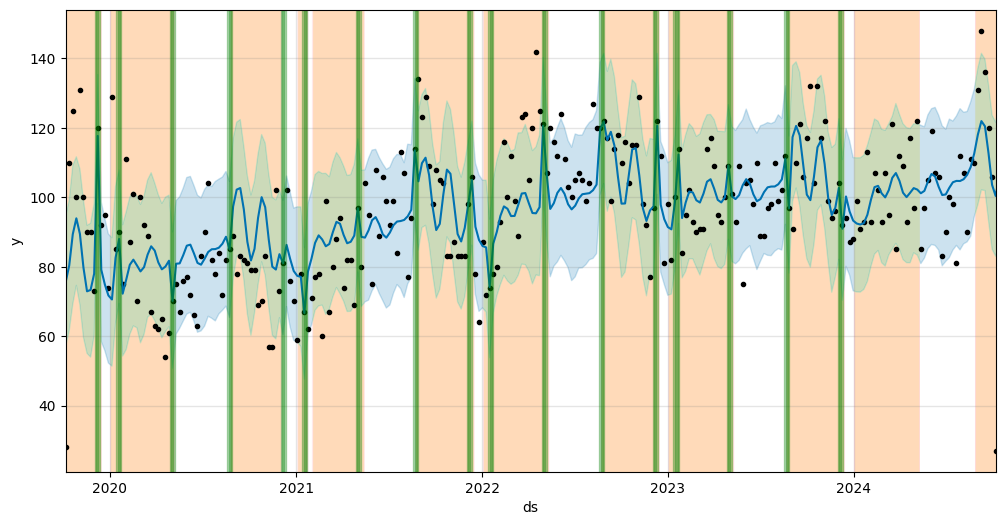

In [64]:
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

# File paths
script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"

# Read the data
df = pd.read_csv(file_path)
# df = pd.read_csv(x)
# Convert DateReported to tz-aware
df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)

# Resample weekly
df_weekly = df.resample("W", on="DateReported").size().reset_index()
df_weekly = df_weekly.rename(columns={"DateReported": "ds", 0: "y"})
df_weekly["ds"] = df_weekly["ds"].dt.tz_localize(None)
df_weekly = df_weekly.sort_values("ds")

# Define UVA holidays
uva_holidays = []
start_year, end_year = 2019, 2023
for year in range(start_year, end_year + 1):
    uva_holidays.extend([
        {"holiday": "Fall semester start", "ds": f"{year}-08-24"},
        {"holiday": "Fall semester end", "ds": f"{year}-12-06"},
        {"holiday": "Winter break start", "ds": f"{year}-12-07"},
        {"holiday": "Winter break end", "ds": f"{year}-01-17"},
        {"holiday": "Spring semester start", "ds": f"{year}-01-18"},
        {"holiday": "Spring semester end", "ds": f"{year}-05-02"},
        {"holiday": "Summer break start", "ds": f"{year}-05-03"},
        {"holiday": "Summer break end", "ds": f"{year}-08-23"},
    ])

# Convert holidays to DataFrame with window effects
uva_holidays = pd.DataFrame(uva_holidays)
uva_holidays["ds"] = pd.to_datetime(uva_holidays["ds"], utc=True)
uva_holidays["lower_window"] = uva_holidays["holiday"].apply(lambda x: -5 if "break" in x else -2)
uva_holidays["upper_window"] = uva_holidays["holiday"].apply(lambda x: 5 if "break" in x else 2)

# Initialize Prophet model with holidays
model2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays
)

# Fit model
model2.fit(df_weekly)

# Make future predictions
future2 = model2.make_future_dataframe(periods=52, freq="W")
forecast2 = model2.predict(future2)

# Define the cutoff date for plotting
cutoff_date = pd.Timestamp("2019-10-06", tz="UTC")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
model2.plot(forecast2, ax=ax)

# Adjust x-axis limits to start from the cutoff date
ax.set_xlim([cutoff_date, df_weekly["ds"].max()])

# Shade in-session periods with extremely transparent shading
in_session_periods = df[df["InSession"] == True]  # Assuming 'InSession' is boolean
for _, row in in_session_periods.iterrows():
    in_session_start = row["DateReported"]
    in_session_end = in_session_start + pd.Timedelta(days=6)  # Example: 1-week period

    # Only shade in-session periods within the plotting range
    if in_session_end >= cutoff_date:
        ax.axvspan(
            in_session_start,
            in_session_end,
            color="peachpuff",  # Subtle color
            alpha=0.01,         # Highly transparent shading
            label="In Session",
            zorder=1            # Place below confidence intervals
        )

# Shade holidays with green
for _, row in uva_holidays.iterrows():
    holiday_start = row["ds"] + pd.Timedelta(days=row["lower_window"])
    holiday_end = row["ds"] + pd.Timedelta(days=row["upper_window"])

    # Only shade holidays within the plotting range
    if holiday_end >= cutoff_date:
        ax.axvspan(
            holiday_start,
            holiday_end,
            color="green",
            alpha=0.3,
            label=row["holiday"],
            zorder=2  # Place above in-session shading
        )

# Show the plot
plt.show()


Shades orange/red when UVA is in session

In [65]:
from sklearn.metrics import mean_absolute_error

# Validation
# Split dataset for validation
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

# Initialize new Prophet model for validation
model_val2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays  # Include holidays in validation model
)

# Fit model on training set
model_val2.fit(train)

# Predict on test set
test_forecast2 = model_val2.predict(test)

# Evaluate model
mae2 = mean_absolute_error(test["y"], test_forecast2["yhat"])
rmse2 = root_mean_squared_error(test["y"], test_forecast2["yhat"])
r2_2 = r2_score(test["y"], test_forecast2["yhat"])

print(f"\nMAE: {mae2}")
print(f"RMSE: {rmse2}")
print(f"R²: {r2_2}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/b49kogu_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/2h6ktdny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17131', 'data', 'file=/tmp/tmpj6mptyxa/b49kogu_.json', 'init=/tmp/tmpj6mptyxa/2h6ktdny.json', 'output', 'file=/tmp/tmpj6mptyxa/prophet_modelf0aalz4j/prophet_model-20250320190903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:09:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:09:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



MAE: 12.05581305533181
RMSE: 17.612384701470653
R²: 0.04751090889728682


# Fitting a Model with InSession *and* Holidays

In [66]:
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

script_dir = Path.cwd()
data_dir = script_dir.parent / "data"
file_path = data_dir / "cleaned_data2.csv"


df = pd.read_csv(file_path)

# df = pd.read_csv(x)

df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)

# Resample weekly, counting occurrences
# Aggregate weekly crime counts
df_weekly = df.resample("W", on="DateReported").size().reset_index(name="y")
df_weekly = df_weekly.rename(columns={"DateReported": "ds"})

df_weekly["ds"] = df_weekly["ds"].dt.tz_localize(None)
df_weekly = df_weekly.sort_values("ds")

# Add InSession indicator
df_weekly["InSession"] = df_weekly["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Define UVA holidays
uva_holidays = []
start_year, end_year = 2019, 2023

for year in range(start_year, end_year + 1):
    uva_holidays.extend([
        {"holiday": "Fall semester start", "ds": f"{year}-08-24"},
        {"holiday": "Fall semester end", "ds": f"{year}-12-06"},
        {"holiday": "Winter break start", "ds": f"{year}-12-07"},
        {"holiday": "Winter break end", "ds": f"{year}-01-17"},
        {"holiday": "Spring semester start", "ds": f"{year}-01-18"},
        {"holiday": "Spring semester end", "ds": f"{year}-05-02"},
        {"holiday": "Summer break start", "ds": f"{year}-05-03"},
        {"holiday": "Summer break end", "ds": f"{year}-08-23"},
    ])

# Convert holidays to DataFrame with window effects
uva_holidays = pd.DataFrame(uva_holidays)
uva_holidays["ds"] = pd.to_datetime(uva_holidays["ds"])
uva_holidays["lower_window"] = uva_holidays["holiday"].apply(lambda x: -5 if "break" in x else -2)
uva_holidays["upper_window"] = uva_holidays["holiday"].apply(lambda x: 5 if "break" in x else 2)

# Initialize and fit the Prophet model
model3 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays
)

# Add InSession as a regressor
model3.add_regressor("InSession")

# Fit model
model3.fit(df_weekly)

# Create future dataframe
future = model3.make_future_dataframe(periods=52, freq="W")  # Weekly predictions for 1 year

# Add InSession to future data
future["InSession"] = future["ds"].apply(lambda x: 1 if x.month in [1, 2, 3, 8, 9, 10, 11] else 0)

# Predict
forecast3 = model3.predict(future)

# Show forecast
forecast3[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

<ipython-input-66-150cc458952f>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DateReported"] = pd.to_datetime(df["DateReported"], errors="coerce", utc=True)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/alj5wl_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/towa9q7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65608', 'data', 'file=/tmp/tmpj6mptyxa/alj5wl_0.json', 'init=/tmp/tmpj6mptyxa/towa9q7_.json', 'output', 'file=/tmp/tmpj6mptyxa/prophet_modelc0ye18bq/prophet_model-20250320190904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:09:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:09:04 - cmdstanpy - INFO - Chai

,ds,yhat,yhat_lower,yhat_upper
0,2019-10-06,76.569836,56.535115,95.039401
1,2019-10-13,81.130270,61.778796,100.719101
2,2019-10-20,90.002494,71.320310,109.831967
3,2019-10-27,94.701572,76.586181,113.162133
4,2019-11-03,90.374387,70.838755,110.311058


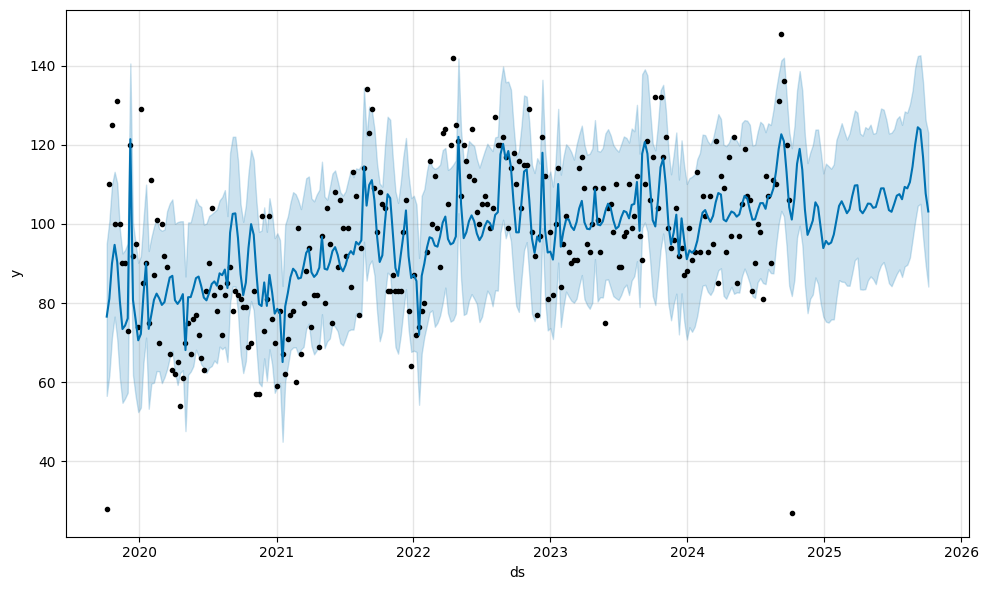

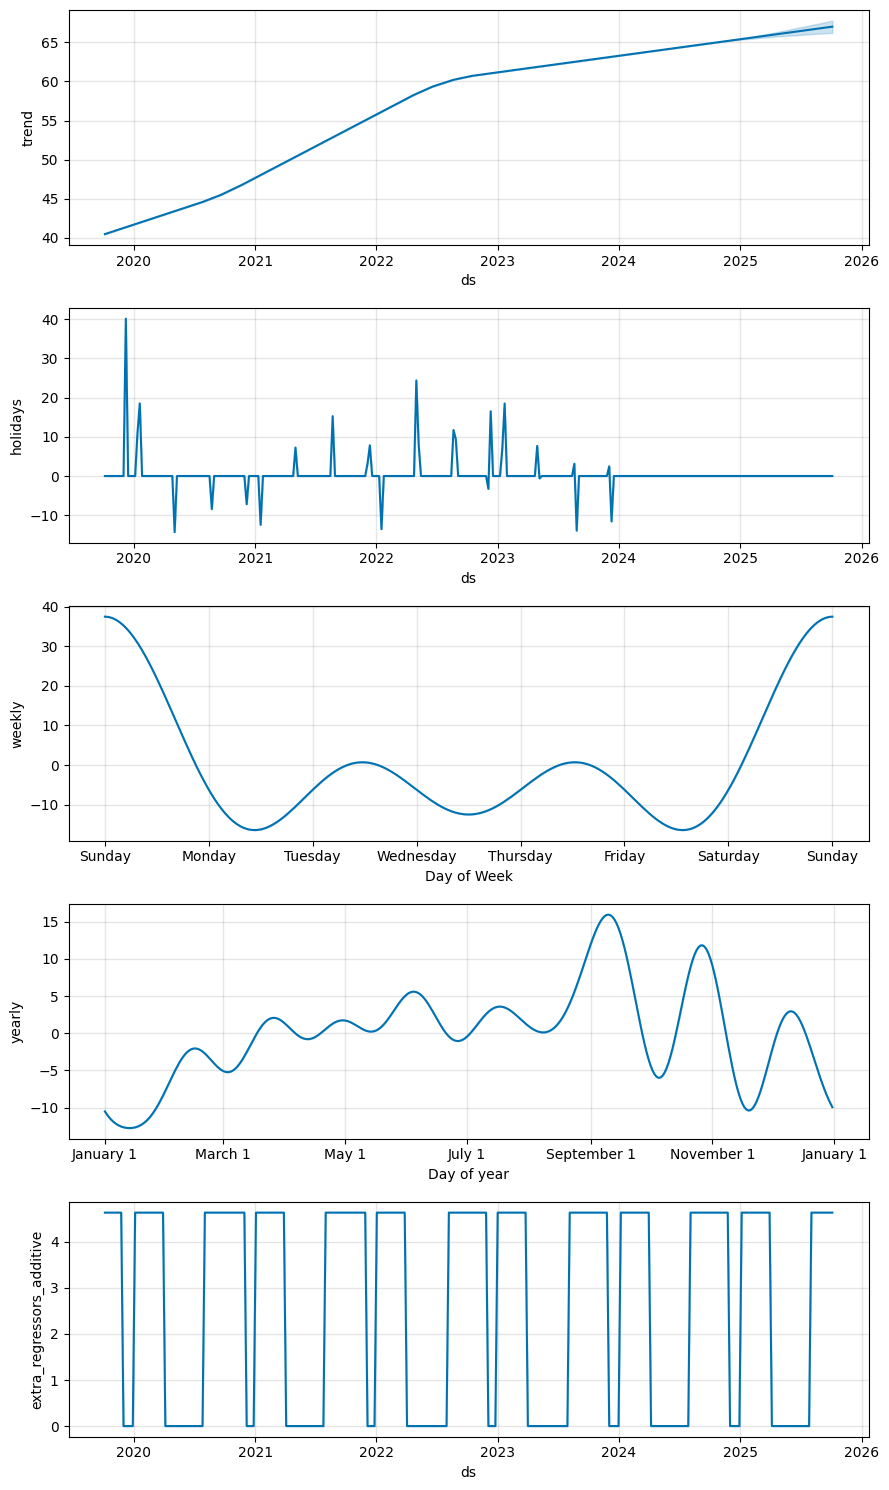

In [67]:
# Visualize forecast
import matplotlib.pyplot as plt

# Plot forecast
fig = model3.plot(forecast3)
plt.show()

# Plot seasonality components
fig2 = model3.plot_components(forecast3)
plt.show()


In [68]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Validation
# Split dataset for validation
train_size = int(len(df_weekly) * 0.8)
train, test = df_weekly.iloc[:train_size], df_weekly.iloc[train_size:]

# Initialize new Prophet model for validation
model_val3 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=uva_holidays  # Include holidays in validation model
)

# Fit model on training set
model_val3.fit(train)

# Predict on test set
test_forecast3 = model_val3.predict(test)

# Evaluate model
mae3 = mean_absolute_error(test["y"], test_forecast3["yhat"])
rmse3 = root_mean_squared_error(test["y"], test_forecast3["yhat"])
r2_3 = r2_score(test["y"], test_forecast3["yhat"])

print(f"Mean Absolute Error (MAE): {mae3}")
print(f"Root Mean Squared Error (RMSE): {rmse3}")
print(f"R-squared (R²): {r2_3}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/knowntp1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj6mptyxa/plknde14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53372', 'data', 'file=/tmp/tmpj6mptyxa/knowntp1.json', 'init=/tmp/tmpj6mptyxa/plknde14.json', 'output', 'file=/tmp/tmpj6mptyxa/prophet_modelrbwafnht/prophet_model-20250320190905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:09:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:09:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 12.05581305533181
Root Mean Squared Error (RMSE): 17.612384701470653
R-squared (R²): 0.04751090889728682


# Comparing the Models

In [69]:
comp_df = pd.DataFrame({
    "Mean Absolute Error (MAE)": [mae1, mae2, mae3],
    "Root Mean Squared Error (RMSE)": [rmse1, rmse2, rmse3],
    "R-squared (R²)": [r2_1, r2_2, r2_3]
}, index=["InSession", "Holidays", "InSession + Holidays"])

comp_df


,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE),R-squared (R²)
InSession,12.134058,17.470291,0.062818
Holidays,12.055813,17.612385,0.047511
InSession + Holidays,12.055813,17.612385,0.047511


# To-Do
1. Double-check Holidays and Holidays + InSession model.
2. See if we can add InSession dates to visualizations.